In [2]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [3]:
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'RH']
full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'rh']

bad_dates = ['2019-08-21', '2019-08-22', '2019-09-24']
GA = full.loc[(full['id'] == 'GA1') & (~full['date'].isin(bad_dates)) , :]

(sec:linear_multi)=
# Multiple Linear Model

So far in this chapter, we've used a single input variable $x$ to predict the outcome
$y$.
Now, we introduce the *multiple linear model* that uses
multiple features to predict (or describe or explain) $y$.
This is useful because having multiple predictors can
improve our model's fit to the data and improve prediction.
After defining the multiple linear model, we use it to improve the single-variable linear model from the previous section that relates the EPA and PurpleAir sensor measurements.

We start by generalizing from a simple linear model to one that includes a second explanatory variable, called $v$. This model is linear in both $x$ and $v$; meaning that for a pair of values for $x$ and $v$, we can describe, explain, or predict $y$ by the linear combination: 

$$ y \approx \theta_0 + \theta_1 x + \theta_2 v.$$

Figure X gives a representation of this model that you might find helpful. 
Notice that for a particular value of $v$, say $v^\star$, we can re-express the above equation as

$$ y \approx (\theta_0 + \theta_2 v^\star) ~+~ \theta_1 x.$$

In other words, when we hold $v$ constant at $v^*$, we have a simple linear relation between $x$ and $y$ with slope $\theta_1$ and intercept $\theta_0 + \theta_2 v^\star$. 
For a different value of $v$, say $v^\dagger$,  we again have a simple linear relationship between $x$ and $y$. The slope for $x$ remains the same and the only change is the intercept, which is now $\theta_0 + \theta_2v^\dagger$.

```{figure} figures/scatterplotMLR.png
---
name: fig:MLR
width: 500px
---

A scatter plot of $(x_i, y_i)$ pairs, the three lines fitted to these points correspond to three different values of $v$. The intercept is different for each value of $v$, but the slope remains the same. 
```

With multiple linear regression, we interpret the coefficient $\theta_1$ of $x$ in the presence of the other variables in the model. {numref}`Figure %s <fig:MLR>` indicates that given the values of the other variables in the model (that's just $v$ in this case),  an increase of 1 unit in $x$ corresponds to a $\theta_1$ change in $y$, on average. One way to visualize this kind of multiple linear relationship is to create facets of scatter plots of $(x, y)$ where in each plot the values of $v$ are roughly the same. We make such a scatter plot for the air quality measurements next, and provide examples of additional visualizations and statistics to examine when fitting a multiple linear model.    

## Example: A Multiple Linear Model for Air Quality

The scientists studying the air quality monitors (see {numref}`Chapter %s <ch:pa>`) were looking for an improved model that incorporated weather factors. That is, they were interested in whether or not
multiple explanatory variables, rather than just one, would make better estimates of $y$. 
One weather variable that they examined was a daily measurement for relative humidity.  Let's consider a two-variable linear model to explain the PurpleAir measurements from the EPA sensor measurements and relative humidity. This model has the following form:

$$ PA \approx \theta_0 + \theta_1 AQ + \theta_2 RH,$$

where $PA$, $AQ$, and $RH$ refer to the variables: PurpleAir average daily measurement, the EPA Air Quality measurement, and relative humidity, respectively.

For a first step, we make a facet plot to compare the relationship between the two air quality measurements for fixed values of humidity. To do this, we transform relative humidity to a categorical variable so each facet consists of the subset of observations with the same level of category.

In [10]:
rh_cat = pd.cut(GA['rh'], bins=[43,50,55,60,78], labels=['<50','50-55','55-60','>60'])

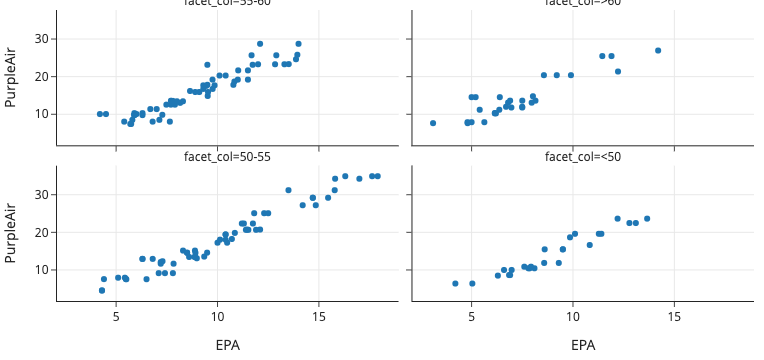

In [11]:
fig = px.scatter(x=GA['pm25aqs'], y=GA['pm25pa'], 
                 facet_col=rh_cat, facet_col_wrap=2,
                labels={
                     "y": "PurpleAir",
                     "x": "EPA"},)
fig

These four plots show a roughly linear relationship between the two sources of air quality measurements. And, the slopes appear to be similar. It's difficult to see if the relative humidity affects the intercept much. 

We also want to examine the pairwise scatter plots between the three features. When we consider linear relationships in multiple regression settings, these relationships may not be uncovered in pairwise plots, but we still need to check them.  

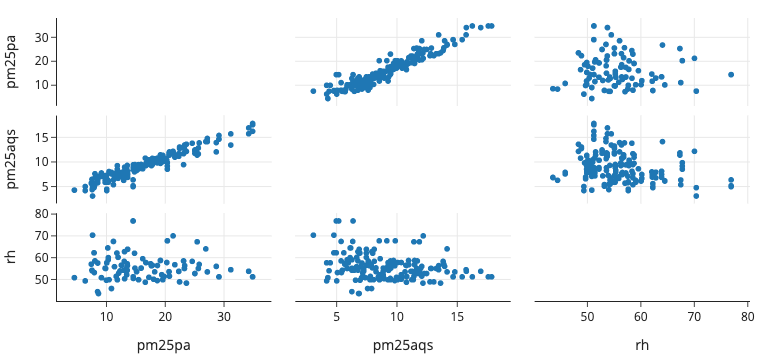

In [5]:
fig = px.scatter_matrix(GA[['pm25pa', 'pm25aqs', 'rh']], 
                 width=450, height=350)
    
fig.update_traces(diagonal_visible=False)

fig

Indeed, the relationship between humidity and air quality does not appear particularly strong. Another pairwise measure we should examine are the correlations between features. 

In [6]:
GA[['pm25pa', 'pm25aqs', 'rh']].corr()

,pm25pa,pm25aqs,rh
pm25pa,1.00,0.95,-0.06
pm25aqs,0.95,1.00,-0.24
rh,-0.06,-0.24,1.00


One small surprise is that relative humidity has a small negative correlation with the EPA measurement of air quality. This suggests that humidity might be helpful in the model.


In the next section, we describe how to fit a multiple linear model. But for now, we use the functionality in `LinearRegression`  to fit the model without explanation as to how it's done:

In [12]:
from sklearn.linear_model import LinearRegression

y = GA[['pm25pa']]
X2 = GA[['pm25aqs', 'rh']]

model2 = LinearRegression().fit(X2, y)

The coefficients of the multiple linear model, including their units, are:

In [13]:
print(f"Intercept: {model2.intercept_[0]:.1f} ppm, \nEPA coefficient: {model2.coef_[0][0]:.2f} ppm/ppm,  \nHumidity coefficient: {model2.coef_[0][1]:.2f} ppm/percent")

Intercept: -15.8 ppm, 
EPA coefficient: 2.25 ppm/ppm,  
Humidity coefficient: 0.21 ppm/percent


The coefficient for humidity in the model adjusts the air quality prediction by 0.21 ppm for each percentage point of relative humidity. 

Lastly, to check the quality of the fit, we make residual plots of the predicted values, the $\hat{y}_i$, and the errors, $y_i - \hat{y}_i$. 

In [10]:
predicted2 = model2.predict(X2)
errors2 = y - predicted2

In [11]:
#fig = px.scatter(y = errors2, x=predicted2,
#                 labels={"y": "error", "x": "predicted values"},
#                 width=350, height=250)

#fig.update_yaxes(range=[-12, 12])

#fig.add_hline(0, line_color='black', line_width=2, line_dash='dash', opacity=1)

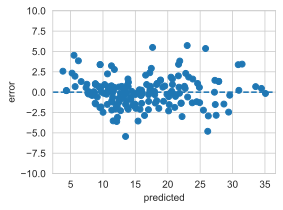

In [12]:
plt.plot(predicted2, errors2, 'o')
plt.xlabel("predicted")
plt.ylabel("error")
plt.ylim((-10, 10))
plt.axhline(y=0, linestyle='dashed')

The residual plot appears to have no clear patterns, which indicates that the model fits pretty well. Next, we compute the standard deviation of the residuals. 

In [14]:
np.std(errors2)

pm25pa    1.82
dtype: float64

The residual standard deviation has been reduced from $2.8$ in the one variable model to $1.8$, which is a good size reduction. 

Correlation doesn't capture the strength of a linear model with more than one explanatory variable. Instead, we adapt the Average Square Error to give us a sense of model fit. In the next section, we describe how to fit the general multiple linear model and look at variations of the ASE to assess model fit. 